In [10]:
% load_ext autoreload
% autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from gecam.data.evt import Evt
from gecam.data.detector import Detector, GRD, CPD
from gecam.data.curve import NetLightCurve
from gecam.fitting.base_polynomial_fitter import BasePolynomialFitter

In [88]:
from gecam.plot.light_curve import LightCurveFigure
import copy


def extrac_net_lc_of_det(det: Detector, time_bin, channel_bin, bg_range, bg_fit_method="2pass",
                         bg_fit_order=1, time_range=None):
    """

    Args:
        det ():
        time_bin ():
        channel_bin ():
        bg_range ():
        bg_fit_method ():
        bg_fit_order ():
        time_range ():

    Returns:

    """
    det_events_all = evt.select_detector(det.number)

    det_events = det_events_all.slice(gain_type=det.gain_type)
    det_lc = det_events.to_light_curve(time_bin=time_bin, channel_bin=channel_bin)
    det_bg_lc = det_lc.fit_background(bg_range, bg_fit_method, bg_fit_order)

    # det_sliced_lc_fig = LightCurveFigure(det_lc.get_plot_data(), trig_time=trig_met, dpi=100)
    # det_sliced_lc_fig.add_background(det_bg_lc.get_plot_data(),
    #                                  bg_time_range=det_bg_lc.bg_time_range)

    det_net_lc = NetLightCurve(det_lc, det_bg_lc)

    return det_net_lc


def extract_net_lc_cumsum(det_list: list, lc_time_bin, channel_bin, lc_bg_range: list, bg_fit_method,
                          bg_fit_order: int):
    """
    extract cumulative sum of net light curve
    Args:
        det_list (list):
        lc_time_bin ():
        lc_channel_range ():
        lc_bg_range ():

    Returns:

    """

    dets_net_lc_x, dets_net_lc_y, dets_net_lc_y_err = None, None, None
    for det in det_list:
        if det.gain_type in ["high", "low"]:
            gain_type_list = [det.gain_type]
        else:
            gain_type_list = ["high", "low"]
        # Calculate the high and low gains separately
        for gain_type in gain_type_list:
            temp_det = copy.deepcopy(det)
            temp_det.set_gain_type(gain_type)

            det_events_all = evt.select_detector(det.number)

            det_events = det_events_all.slice(gain_type=det.gain_type)
            det_lc = det_events.to_light_curve(time_bin=lc_time_bin, channel_bin=channel_bin)
            det_bg_lc = det_lc.fit_background(lc_bg_range, bg_fit_method, bg_fit_order)

            # det_sliced_lc_fig = LightCurveFigure(det_lc.get_plot_data(), trig_time=trig_met, dpi=100)
            # det_sliced_lc_fig.add_background(det_bg_lc.get_plot_data(),
            #                                  bg_time_range=det_bg_lc.bg_time_range)

            det_net_lc = NetLightCurve(det_lc, det_bg_lc)

            net_x, net_y, net_y_err = det_net_lc.get_data()
            if dets_net_lc_x is None:
                dets_net_lc_x, dets_net_lc_y, dets_net_lc_y_err = net_x, net_y, np.square(net_y_err)
            else:
                dets_net_lc_y = dets_net_lc_y + net_y
                dets_net_lc_y_err = dets_net_lc_y_err + np.square(net_y_err)

    plt.figure()
    plt.plot(dets_net_lc_x[:-1], np.sum(dets_net_lc_y, axis=0))
    plt.show()

    # TODO: 误差待确定
    # np.sqrt( np.square(det0_net_err) +np.square(det1_net_err)+..+)
    dets_net_lc_y_err = np.sqrt(dets_net_lc_y_err)

    dets_net_lc_y_cumsum = np.cumsum(np.sum(dets_net_lc_y, axis=0))
    dets_net_lc_y_cumsum_err = dets_net_lc_y_err

    return dets_net_lc_x, dets_net_lc_y_cumsum, dets_net_lc_y_cumsum_err


def _get_range_index(x, x_range):
    start_index = np.where(x >= x_range[0])[0][0]
    stop_index = np.where(x >= x_range[1])[0][0]
    if stop_index - start_index <= 0:
        stop_index = start_index + 1

    return start_index, stop_index


def _trunc_bg(x, y, bg_range):
    """
    truncate background range x and y
    Args:
        x ():
        y ():
        bg_range ():

    Returns:

    """

    bg0_index_start, bg0_index_stop = _get_range_index(x, bg_range)

    bg0_x = x[bg0_index_start:bg0_index_stop]
    y_on_bg0 = y[bg0_index_start:bg0_index_stop]

    return bg0_x, y_on_bg0


def _search_index_of_cross_point(line0, line1):
    sub_line_sign = np.sign(line0 - line1)

    start_index_list = np.where((sub_line_sign[1:] + sub_line_sign[:-1]) == 0)[0]
    if len(start_index_list) == 0:
        return None
    else:
        return start_index_list


def cal_burst_duration_by_counts(evt_path, det_list, lc_time_bin, lc_channel_range, lc_energy_range,
                                 lc_bg_range,
                                 lc_bg_fit_order, only_recommend, lc_time_range=None):
    """
    calculate burst duration by counts

    Args:
        evt_path ():
        det_list (list of Detector):
        lc_time_bin ():
        lc_bg_range ():
        lc_bg_fit_order ():
        only_recommend ():

    Returns:

    """

    evt = Evt.open(evt_path)
    trig_met = evt.info.trig_met

    if lc_time_range is None:
        lc_time_range = [min(lc_bg_range)[0], max(lc_bg_range)[1]]

    cumsum_lc_x, cumsum_lc_y, cumsum_lc_y_err = extract_net_lc_cumsum(det_list, lc_time_bin, lc_channel_range,
                                                                      lc_bg_range)
    bg0_x, cumsum_y_on_bg0 = _trunc_bg(cumsum_lc_x, cumsum_lc_y, lc_bg_range[0])
    bg1_x, cumsum_y_on_bg1 = _trunc_bg(cumsum_lc_x, cumsum_lc_y, lc_bg_range[1])

    bg0_fitting = BasePolynomialFitter()
    bg0_fitting.fit(bg0_x, cumsum_y_on_bg0, fit_order=lc_bg_fit_order)
    cumsum_bg0_lc_y, cumsum_bg0_lc_y_err = bg0_fitting.interpolate(cumsum_lc_x[:-1])

    bg1_fitting = BasePolynomialFitter()
    bg1_fitting.fit(bg1_x, cumsum_y_on_bg1, fit_order=lc_bg_fit_order)
    cumsum_bg1_lc_y, cumsum_bg1_lc_y_err = bg1_fitting.interpolate(cumsum_lc_x[:-1])

    bg0_cross_index_list = _search_index_of_cross_point(cumsum_lc_y, cumsum_bg0_lc_y)
    bg1_cross_index_list = _search_index_of_cross_point(cumsum_lc_y, cumsum_bg1_lc_y)

    if bg0_cross_index_list is None:
        T100_start_index = _get_range_index(cumsum_lc_x, lc_bg_range[0])[-1]
    else:
        T100_start_index = bg0_cross_index_list[-1]
    T100_start_x = cumsum_lc_x[T100_start_index]
    T100_start_y = cumsum_lc_y[T100_start_index]

    if bg1_cross_index_list is None:
        T100_stop_index = _get_range_index(cumsum_lc_x, lc_bg_range[1])[0]
    else:
        T100_stop_index = bg1_cross_index_list[0]
    T100_stop_x = cumsum_lc_x[T100_stop_index]
    T100_stop_y = cumsum_lc_y[T100_stop_index]

In [2]:

evt_path = r"D:\sougou_download\gbg_evt_tn210511_112749_fb_v00.fits"
evt = Evt.open(evt_path)
trig_met = evt.info.trig_met

C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:266: RankWarning: The fit may be poorly conditioned
  self._coeffs[i] = self._weighted_leastsq(X, y[i], w[i], False)
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 69, 73, 76, 359, 362, 364, 365, 367, 368, 370, 373, 377, 382, 400

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 18, 170, 464

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:266: RankWarning: The fit may be poorly conditioned
  self._coeffs[i] = self._weighted_least

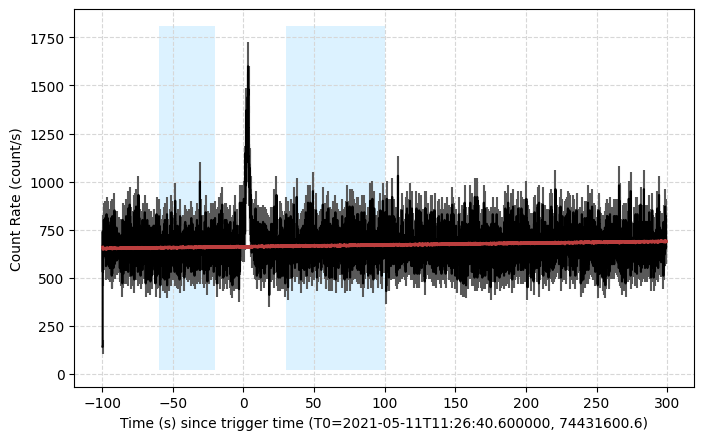

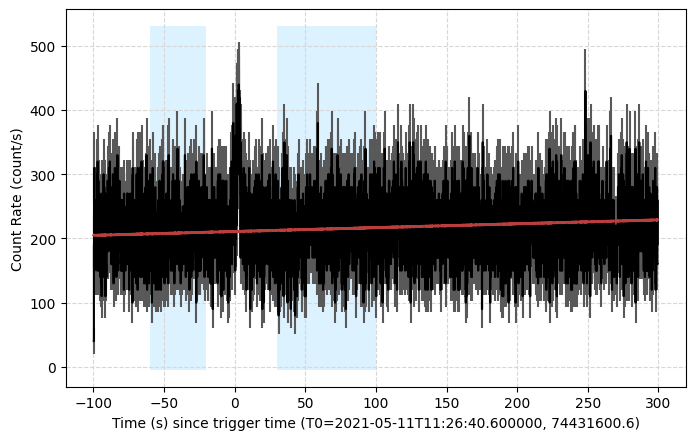

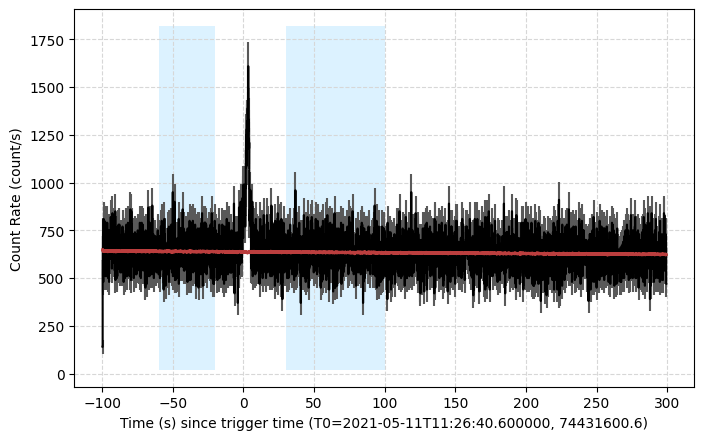

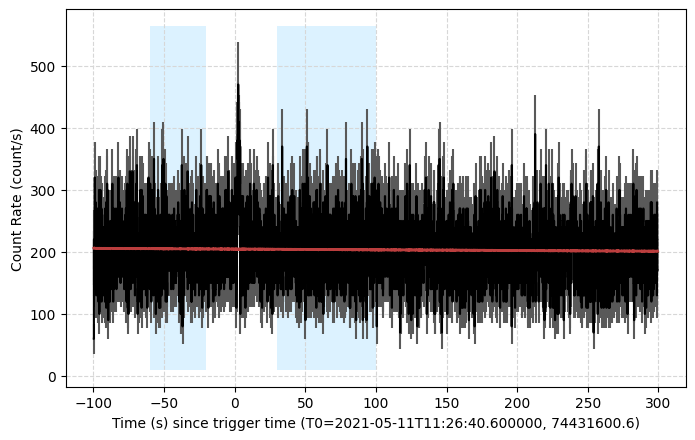

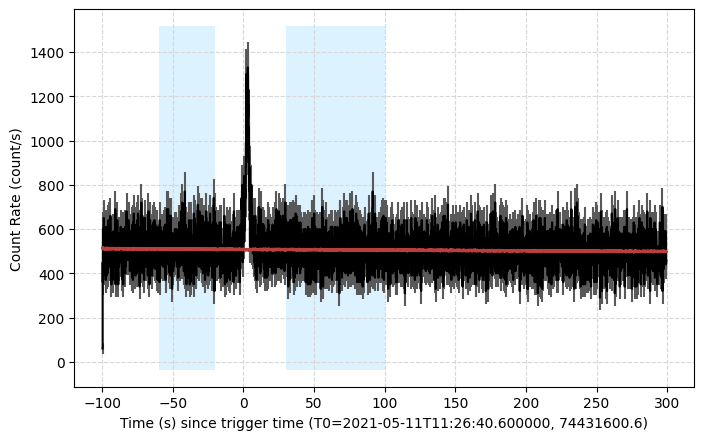

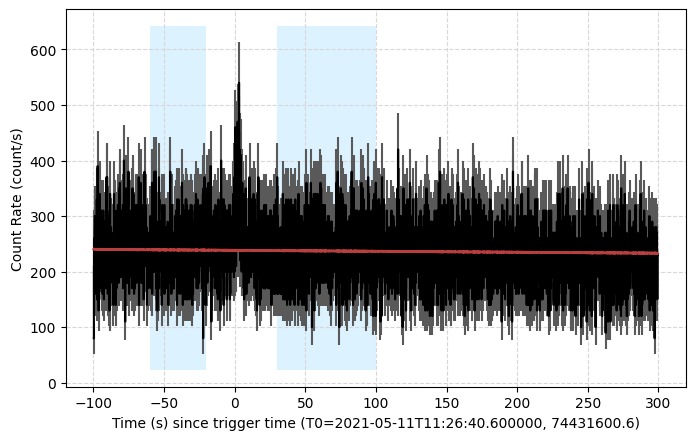

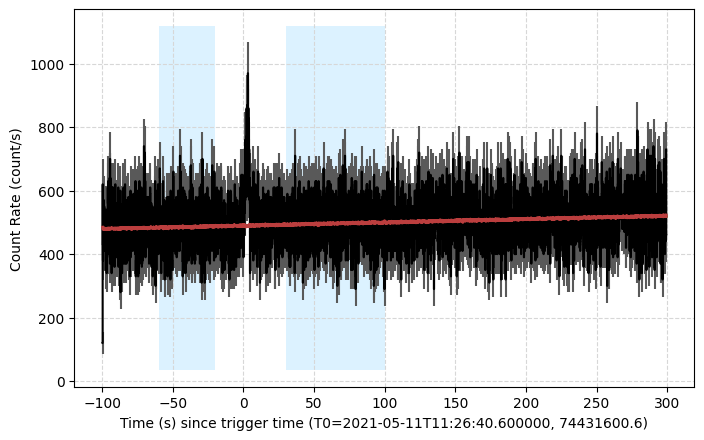

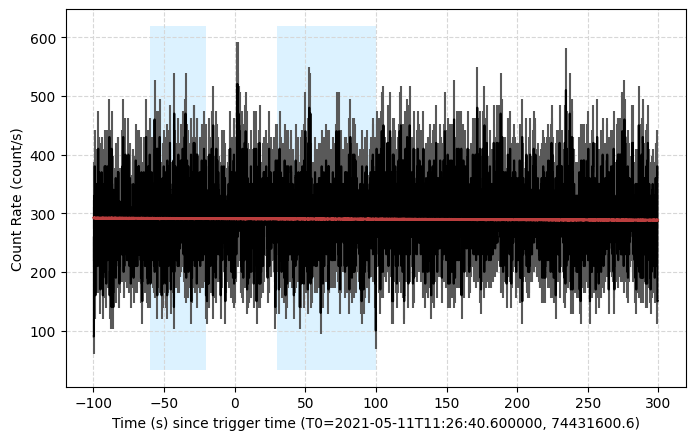

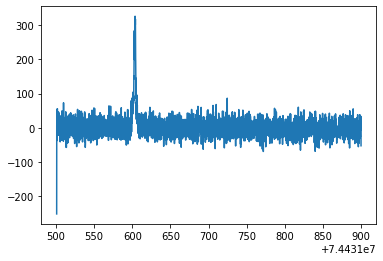

In [110]:
det_list = [GRD(18, gain_type="both"), GRD(17, gain_type="both"), GRD(16, gain_type="both"), GRD(15, gain_type="both")]
lc_bg_range = bg_time_range_list = [[trig_met - 60, trig_met - 20], [trig_met + 30, trig_met + 100]]
cumsum_lc_x, cumsum_lc_y, cumsum_lc_y_err = extract_net_lc_cumsum(det_list, 0.1, 1, lc_bg_range=lc_bg_range)

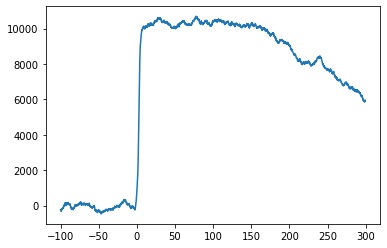

In [111]:
plt.plot(cumsum_lc_x[:-1] - trig_met, cumsum_lc_y)
# plt.xlim([-10,20])

In [112]:
bg0_x, cumsum_y_on_bg0 = _trunc_bg(cumsum_lc_x, cumsum_lc_y, lc_bg_range[0])
bg1_x, cumsum_y_on_bg1 = _trunc_bg(cumsum_lc_x, cumsum_lc_y, lc_bg_range[1])

bg0_fitting = BasePolynomialFitter()
bg0_fitting.fit(bg0_x, cumsum_y_on_bg0, fit_order=1)
cumsum_bg0_lc_y, cumsum_bg0_lc_y_err = bg0_fitting.interpolate(cumsum_lc_x[:-1])

bg1_fitting = BasePolynomialFitter()
bg1_fitting.fit(bg1_x, cumsum_y_on_bg1, fit_order=1)
cumsum_bg1_lc_y, cumsum_bg1_lc_y_err = bg1_fitting.interpolate(cumsum_lc_x[:-1])

C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\base_polynomial_fitter.py:47: RuntimeWarning: invalid value encountered in sqrt
  y_err = np.sqrt(y)


(-50.0, 100.0)

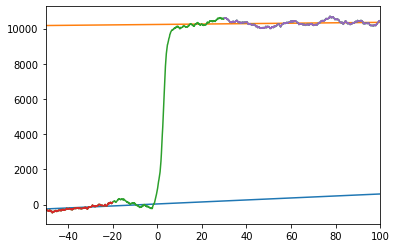

In [113]:
plt.plot(cumsum_lc_x[:-1] - trig_met, cumsum_bg0_lc_y)
plt.plot(cumsum_lc_x[:-1] - trig_met, cumsum_bg1_lc_y)
plt.plot(cumsum_lc_x[:-1] - trig_met, cumsum_lc_y)
plt.plot(bg0_x - trig_met, cumsum_y_on_bg0)
plt.plot(bg1_x - trig_met, cumsum_y_on_bg1)
plt.xlim([-50, 100])

In [114]:
def search_cross_index(line0, line1, choose_result_index=None, default=None):
    cross_index_list = _search_index_of_cross_point(line0, line1)

    if cross_index_list is None:
        return default
    else:
        if choose_result_index is None:
            return cross_index_list[0]
        else:
            return cross_index_list[choose_result_index]


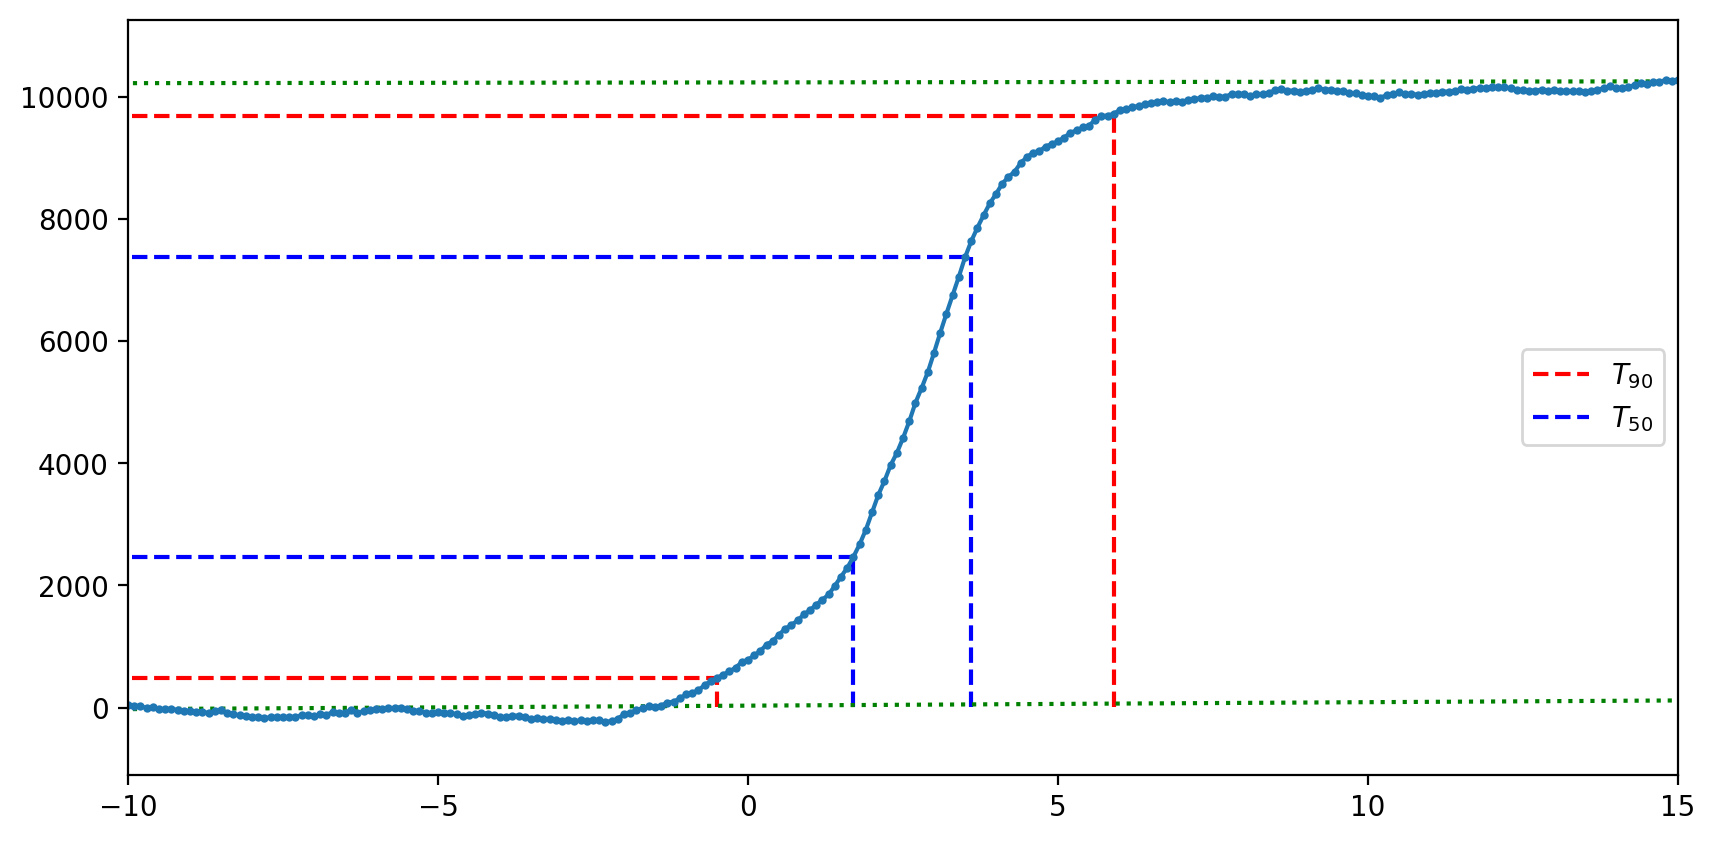

In [156]:

T100_start_index = search_cross_index(cumsum_lc_y, cumsum_bg0_lc_y, -1,
                                      default=_get_range_index(cumsum_lc_x, lc_bg_range[0])[-1])
T100_stop_index = search_cross_index(cumsum_lc_y, cumsum_bg1_lc_y, 0,
                                     default=_get_range_index(cumsum_lc_x, lc_bg_range[1])[0])

cumsum_lc_x_T100 = cumsum_lc_x[T100_start_index:T100_stop_index + 1]
cumsum_lc_y_T100 = cumsum_lc_y[T100_start_index:T100_stop_index]

T100_counts_interval = cumsum_lc_y_T100[-1] - cumsum_lc_y_T100[0]
T90_counts_start = cumsum_lc_y_T100[0] + T100_counts_interval * 0.05
T90_counts_stop = cumsum_lc_y_T100[-1] - T100_counts_interval * 0.05

T50_counts_start = cumsum_lc_y_T100[0] + T100_counts_interval * 0.25
T50_counts_stop = cumsum_lc_y_T100[-1] - T100_counts_interval * 0.25

T90_start_index = search_cross_index(cumsum_lc_y_T100, np.ones(cumsum_lc_y_T100.shape) * T90_counts_start, -1)
T90_stop_index = search_cross_index(cumsum_lc_y_T100, np.ones(cumsum_lc_y_T100.shape) * T90_counts_stop, 0)

T50_start_index = search_cross_index(cumsum_lc_y_T100, np.ones(cumsum_lc_y_T100.shape) * T50_counts_start, -1)
T50_stop_index = search_cross_index(cumsum_lc_y_T100, np.ones(cumsum_lc_y_T100.shape) * T50_counts_stop, 0)

cumsum_lc_x_T90 = cumsum_lc_x_T100[T90_start_index:T90_stop_index + 1]
cumsum_lc_y_T90 = cumsum_lc_y_T100[T90_start_index:T90_stop_index]

cumsum_lc_x_T50 = cumsum_lc_x_T100[T50_start_index:T50_stop_index + 1]
cumsum_lc_y_T50 = cumsum_lc_y_T100[T50_start_index:T50_stop_index]

T100 = cumsum_lc_x_T100[-1] - cumsum_lc_x_T100[0]
T90 = cumsum_lc_x_T90[-1] - cumsum_lc_x_T90[0]
T50 = cumsum_lc_x_T50[-1] - cumsum_lc_x_T50[0]

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(cumsum_lc_x[:-1] - trig_met, cumsum_bg0_lc_y, color="green", linestyle='dotted')
plt.plot(cumsum_lc_x[:-1] - trig_met, cumsum_bg1_lc_y, color="green", linestyle='dotted')
plt.plot(cumsum_lc_x[:-1] - trig_met, cumsum_lc_y, marker="o", markersize=2)

plt.vlines(cumsum_lc_x_T90[0] - trig_met, ymin=cumsum_lc_y_T100[0], ymax=cumsum_lc_y_T90[0],
           color="red", linestyle='--', label="$T_{90}$")
plt.hlines(cumsum_lc_y_T90[0], xmin=cumsum_lc_x[0] - trig_met, xmax=cumsum_lc_x_T90[0] - trig_met, color="red",
           linestyle='--')

plt.vlines(cumsum_lc_x_T90[-1] - trig_met, ymin=cumsum_lc_y_T100[0], ymax=cumsum_lc_y_T90[-1], color="red",
           linestyle='--')
plt.hlines(cumsum_lc_y_T90[-1], xmin=cumsum_lc_x[0] - trig_met, xmax=cumsum_lc_x_T90[-1] - trig_met, color="red",
           linestyle='--')

plt.vlines(cumsum_lc_x_T50[0] - trig_met, ymin=cumsum_lc_y_T100[0], ymax=cumsum_lc_y_T50[0],
           color="blue", linestyle='--', label="$T_{50}$")
plt.hlines(cumsum_lc_y_T50[0], xmin=cumsum_lc_x[0] - trig_met, xmax=cumsum_lc_x_T50[0] - trig_met, color="blue",
           linestyle='--')

plt.vlines(cumsum_lc_x_T50[-1] - trig_met, ymin=cumsum_lc_y_T100[0], ymax=cumsum_lc_y_T50[-1], color="blue",
           linestyle='--')
plt.hlines(cumsum_lc_y_T50[-1], xmin=cumsum_lc_x[0] - trig_met, xmax=cumsum_lc_x_T50[-1] - trig_met, color="blue",
           linestyle='--')

plt.xlim([-10, 15])
plt.legend(loc="center right")

In [143]:
cumsum_lc_x_T90[0] - trig_met

-0.4999999701976776

(array([46, 69, 89, 97], dtype=int64),
 array([113, 114, 116, 119, 121, 139, 155, 162, 171, 184, 187, 191, 198,
        210, 211, 213, 218, 219], dtype=int64))

In [1]:
%load_ext autoreload
%autoreload 2
from gecam.data.evt import Evt
from gecam.analysis.burst_duration import BurstDuration
from gecam.data.detector import Detector, GRD

In [2]:
evt_path = r"D:\sougou_download\gbg_evt_tn210511_112749_fb_v00.fits"
evt = Evt.open(evt_path)

trig_met = evt.info.trig_met
det_list = [GRD(18, gain_type="both"), GRD(17, gain_type="both"), GRD(16, gain_type="both"), GRD(15, gain_type="both")]
# det_list = [GRD(18, gain_type="both")]
lc_bg_range = [[trig_met - 30, trig_met - 5], [trig_met + 15, trig_met + 40]]
only_recommend = True

time_bin = 0.01
channel_bin = 1
lc_time_range = [trig_met - 30, trig_met + 40]

In [3]:

duration_obj = BurstDuration()
dets_net_lc_dic,cumsum_lc_data = duration_obj.cal_net_light_curve_cumsum(evt, det_list, time_bin, channel_bin, lc_bg_range=lc_bg_range,
                                               lc_channel_range=None,
                                               bg_fit_method="2pass", bg_fit_order=1, only_recommend=only_recommend,
                                               lc_time_range=lc_time_range)

# time_bins, dets_total_lc_y, dets_net_lc_y, dets_net_lc_y_err, lc_bg_range = temp

bg18H
bg18L
bg17H
bg17L
bg16H
bg16L
bg15H
bg15L


## 查看合并能段的净光变

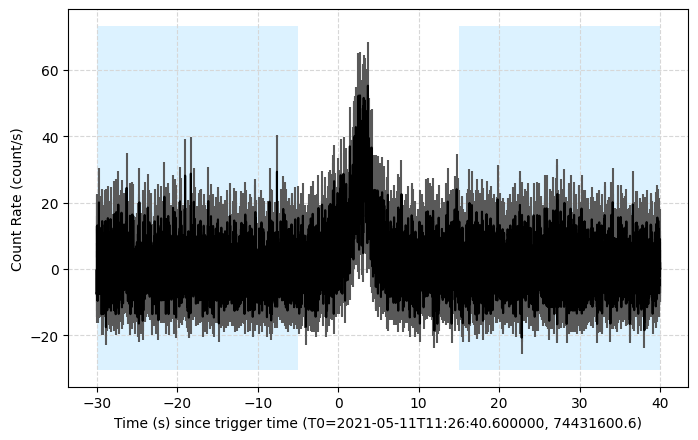

In [4]:
from gecam.plot.light_curve import LightCurveFigure

net_lc_x,net_lc_y,net_lc_y_err=duration_obj.net_lc_1D_data

det_sliced_lc_fig = LightCurveFigure((net_lc_x[:-1],net_lc_y,net_lc_y_err), trig_time=duration_obj.evt_info.trig_met, dpi=100)
det_sliced_lc_fig.add_background(bg_time_range=lc_bg_range)

## 查看净光变的累计计数曲线

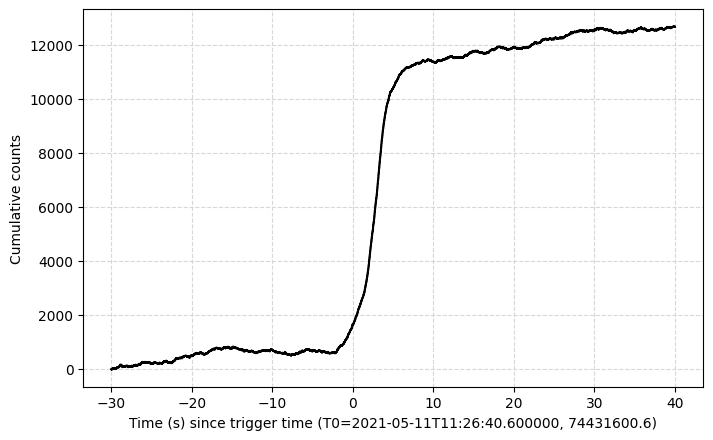

In [5]:
# 查看净光变的累计计数曲线，方便选取累计曲线的本底范围
set_time_range=None
cumsum_lc_fig = duration_obj.plot_light_curve_cumsum(set_time_range=set_time_range)

## 计算T90,T50

In [6]:
# 累计曲线的本底范围
cumsum_bg_range = [[trig_met - 30, trig_met - 5], [trig_met + 9, trig_met + 20]]
t90, t90_err,t50, t50_err=duration_obj.cal_burst_duration_by_cumsum_counts(cumsum_bg_range)

print("T90:",t90,"T90误差:",t90_err)
print("T50:",t50,"T50误差:",t50_err)

T90: 8.130004361271858 T90误差: 0.2641970379987175
T50: 2.1600011587142944 T50误差: 0.022360691770201273


In [6]:
# 累计曲线的本底范围
cumsum_bg_range = [[trig_met - 30, trig_met - 5], [trig_met + 9, trig_met + 20]]
t90, t90_err,t50, t50_err=duration_obj.cal_burst_duration_by_cumsum_counts(cumsum_bg_range)

print("T90:",t90,"T90误差:",t90_err)
print("T50:",t50,"T50误差:",t50_err)

T90: 8.210004404187202 T90误差: 0.2641970379987175
T50: 2.1600011587142944 T50误差: 0.022360691770201273


## 画出T90的范围

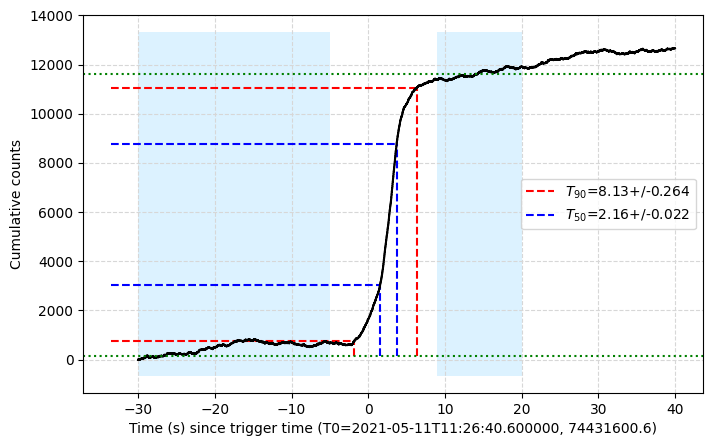

In [7]:
# set_time_range 用于限制图像的起始时间

# set_time_range = [trig_met - 10, trig_met + 10]
set_time_range=None
cumsum_lc_fig = duration_obj.plot_light_curve_cumsum(set_time_range=set_time_range)

IndexError: list index out of range

In [11]:
from gecam.analysis import burst_duration
import numpy as np

In [34]:
# 1. 如何设置order
# 2. 如何计算T100

result = burst_duration.calc_duration(time_bins[:-1], np.sum(dets_total_lc_y, axis=0), np.sum(dets_net_lc_y, axis=0),
                                      np.sqrt(np.sum(dets_net_lc_y_err, axis=0)), 0.9,
                                      lc_bg_range[0], lc_bg_range[1])
result

(16.110008642077446,
 0.5414797452994504,
 (74431598.78999902, 74431614.90000767),
 (318, 1929))

In [86]:
# 1. 如何设置order
# 2. 如何计算T100，设置f大于0.96会存在
# 3.
lc_bg_range = [[trig_met - 30, trig_met - 5], [trig_met + 9, trig_met + 20]]
net_y = np.sum(dets_net_lc_y, axis=0)
net_y_err = np.sqrt(np.sum(np.square(dets_net_lc_y_err), axis=0))

net_x = time_bins[:-1] + np.diff(time_bins) / 2

result = burst_duration.calc_duration(net_x, np.sum(dets_total_lc_y, axis=0), net_y,
                                      net_y_err, 0.96, lc_bg_range[0], lc_bg_range[1])

result



(13.6100073158741,
 0.15000009536743164,
 (74431595.6049973, 74431609.21500462),
 (0, 1361))

In [70]:
T, T_err, (T_start_met, T_stop_met), (T_start_index, T_stop_index) = result

In [71]:
import matplotlib.pyplot as plt

In [72]:
x = time_bins[:-1]
y = np.sum(dets_net_lc_y, axis=0)
y_cumsum = np.cumsum(y)

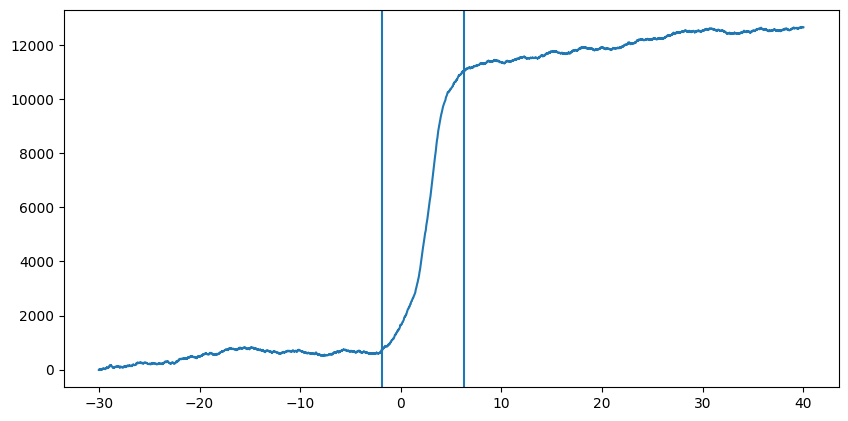

In [73]:
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x - trig_met, y_cumsum)
plt.axvline(T_start_met - trig_met)
plt.axvline(T_stop_met - trig_met)





In [6]:

# 1、提取全光变（高低增益分开计算）
# 2、根据选定的本底区域，拟合本底（薛王陈）
# 3、扣除本底得到净光变
# 4. 合并净光变并累计求和得到累计曲线

# 手动限制光变的时间范围，防止事例文件太大耗费过多时间和内存
lc_time_range = [trig_met - 30, trig_met + 40]

duration_obj = BurstDuration()
lc_dic, cumsum_lc_data = duration_obj.cal_net_light_curve_cumsum(evt, det_list, time_bin, channel_bin,
                                                                 lc_bg_range=lc_bg_range,
                                                                 lc_channel_range=None,
                                                                 bg_fit_method="2pass", bg_fit_order=1,
                                                                 only_recommend=only_recommend,
                                                                 lc_time_range=lc_time_range)

bg18H


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:266: RankWarning: The fit may be poorly conditioned
  self._coeffs[i] = self._weighted_leastsq(X, y[i], w[i], False)
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 20

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg18L


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 73, 74, 78, 79, 82, 86, 353, 354, 357, 358, 367, 374, 378, 380, 384, 387, 400

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg17H


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 18, 464

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg17L


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 78, 79, 81, 83, 84, 85, 89, 93, 108, 357, 369, 378, 383, 384, 388, 389, 403

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg16H
bg16L


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 75, 78, 79, 348, 349, 351, 357, 360, 361, 362, 365, 367, 368, 371, 374, 375, 377, 380, 381, 386, 387, 389, 393

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg15H


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 21, 178

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg15L


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 72, 89, 355, 358, 364, 366, 367, 369, 370, 372, 373, 375, 381, 382

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning
C:\Users\10500\PycharmProjects\gecamTools\gecam\analysis\burst_duration.py:302: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.sum(dets_net_lc_y, axis=0)), 0.5,


IndexError: index 0 is out of bounds for axis 0 with size 0

总光变是否修正死时间 True
本底光变是否修正死时间 True
净光变是否修正死时间 True


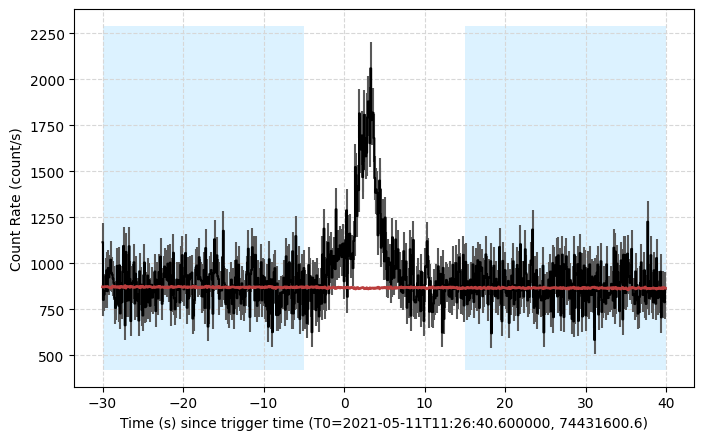

In [38]:
# 查看部分探头的本底拟合结果
from gecam.plot.light_curve import LightCurveFigure

det_net_lc = lc_dic["bg18H"]

det_lc = det_net_lc.total_lc
det_lc.correct_by_dead_time()  #修正死时间

det_bg_lc = det_net_lc.bg_lc
# 检查是否修正死时间
print("总光变是否修正死时间", det_lc.flag_correct_by_dead_time)
print("本底光变是否修正死时间", det_bg_lc.flag_correct_by_dead_time)
print("净光变是否修正死时间", det_net_lc.flag_correct_by_dead_time)

det_sliced_lc_fig = LightCurveFigure(det_lc.get_plot_data(), trig_time=duration_obj.evt_info.trig_met, dpi=100)
det_sliced_lc_fig.add_background(det_bg_lc.get_plot_data(), bg_time_range=det_bg_lc.bg_time_range)
# det_sliced_lc_fig.set_xlim((-30,20))

In [4]:
# 累积曲线的范围在两段本底内部

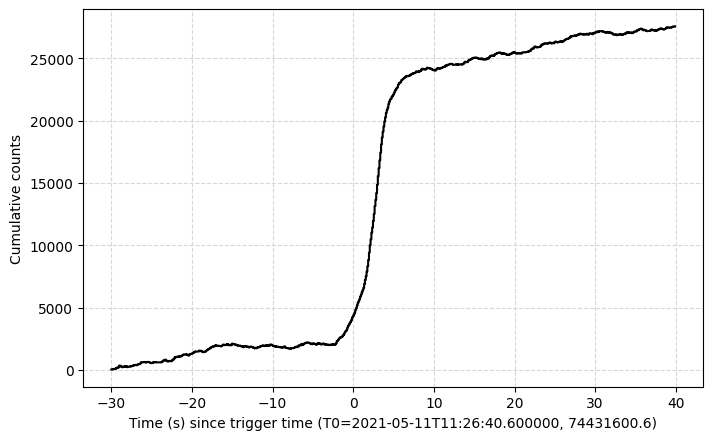

In [39]:
# 画多探测器叠加的净光变的累计计数曲线
duration_obj.plot_light_curve_cumsum()

In [42]:
# 拟合两段本底区域的累计曲线（多项式拟合）
# 根据拟合曲线和累计曲线的交点作为100%的区域
# 根据90%和50%占比的时间段为T90和T50
cumsum_lc_bg_range = [[trig_met - 20, trig_met - 5], [trig_met + 15, trig_met + 30]]
cumsum_lc_bg_fit_order = 1

cumsum_lc_x, cumsum_lc_y, cumsum_lc_y_err = cumsum_lc_data
duration_obj.cal_burst_duration_by_cumsum_counts(cumsum_lc_x, cumsum_lc_y, cumsum_lc_y_err, cumsum_lc_bg_range,
                                                 cumsum_lc_bg_fit_order)

T90_start_met, T90, T90_err = duration_obj.T90
T50_start_met, T50, T50_err = duration_obj.T50

print(f"T90起始met：{T90_start_met}, T90:{round(T90, 4)}, T90误差:{round(T90_err, 4)}")
print(f"T50起始met：{T50_start_met}, T50:{round(T50, 4)}, T50误差:{round(T50_err, 4)}")

T90起始met：74431599.70000005, T90:6.0, T90误差:0
T50起始met：74431602.0999999, T50:1.9, T50误差:0


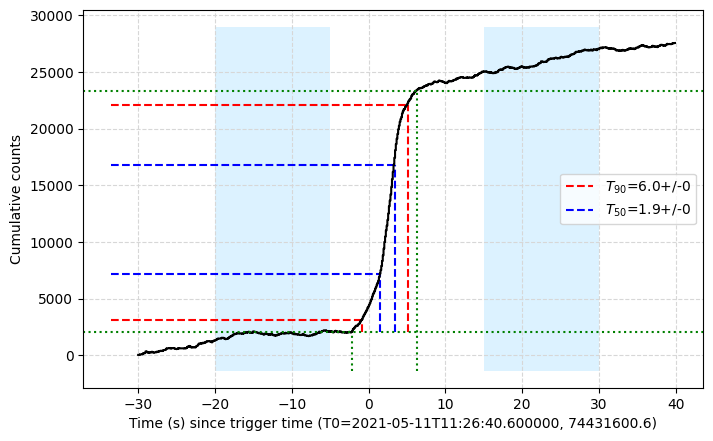

In [43]:
# 添加设置起始时间
cumsum_lc_fig = duration_obj.plot_light_curve_cumsum(show_bg=True, start_time="")
# cumsum_lc_fig.set_xlim((-50,80))
# cumsum_lc_fig.set_xlim((-5,10))

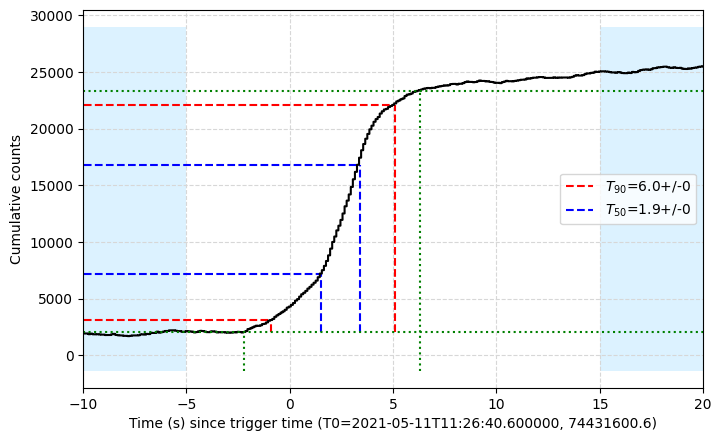

In [44]:
cumsum_lc_fig = duration_obj.plot_light_curve_cumsum(show_bg=True)
# cumsum_lc_fig.set_xlim((-50,80))
cumsum_lc_fig.set_xlim((-10, 20))

# 起点的纵坐标从0开始

In [24]:
T90_start_met, T90, T90_err = duration_obj.T90

T90_start_met, T90, T90_err

(74431600.10000002, 8.199999511241913, 0)